### Import and Configuration:

In [8]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

random.seed(149)

In [3]:
def loaddata():
    return pd.read_csv('food_coded.csv')
data = loaddata()

## Preprocessing:

#### Employment:

In [21]:
# employment, sample from prob dist and fill the missing values
probibility = data['employment'].value_counts() / data['employment'].value_counts().sum().tolist()
count_of_nas = pd.isna(data['employment']).sum()
values = probibility.cumsum().searchsorted(np.random.uniform(size=count_of_nas))
for i in xrange(len(values)):
    if values[i] == 0: values[i] = 2
    elif values[i] == 1: values[i] = 3
    else: values[i] = 1
index = 0
for i in xrange(len(data.employment)):
    if pd.isnull(data.iloc[i].employment):
        data.loc[i, 'employment'] = values[index]
        index += 1

#### Sports:

We took a look on the students' answers and compiled a list of their sports, then replaced their text answers with a comma seperated list of the sports they played. Morever, we replaced any other answers like "I don't play sports" and "not really" with an NA

In [24]:
sports = ['car racing', 'basketball', 'softball', 'soccer', 'field hockey', 'running', 'volleyball', 'hockey', \
          'dancing', 'tennis', 'gym', 'football', 'lacrosse', 'snowboarding', 'wrestling', 'rowing', 'skiing', \
          'water polo', 'baseball', 'horse back riding', 'golf']
sports.sort(key=len, reverse=True)
print data.type_sports.value_counts().sample(frac=1).head(15)
def func(x):
    output = ''
    for sport in sports:
        if pd.isnull(x): continue
        x = x.lower()
        if x.find(sport) != -1:
            output += sport + ','
            x.replace(sport, '')
    if len(output) == 0: return np.NaN
    return output[:-1]
data.type_sports = data.type_sports.apply(func=func)

print "\n\nAfter Processing:\n", data.type_sports.value_counts().head(15)

No, I don't play sport.                     1
 None                                       1
wrestling                                   1
hockey, soccer, golf                        1
basketball                                  1
rowing                                      1
softball and basketball                     1
Football, Basketball, Volleyball, Golf      1
Recreational Basketball, Equestrian Team    1
Fotball                                     1
Hockey                                      7
Running                                     1
Collegiate Water Polo                       1
Basketball                                  2
field hockey                                2
Name: type_sports, dtype: int64


After Processing:
hockey                 12
softball               9 
soccer                 8 
volleyball             7 
basketball             6 
wrestling              4 
lacrosse               4 
tennis                 3 
skiing                 3 
field hockey,hockey    2

### Plots:

In [76]:
# TODO: Remove useless columns: non-coded columns
columns_we7sha = ["life_rewarding", "comfort_food_reasons_coded", "comfort_food_reasons"]

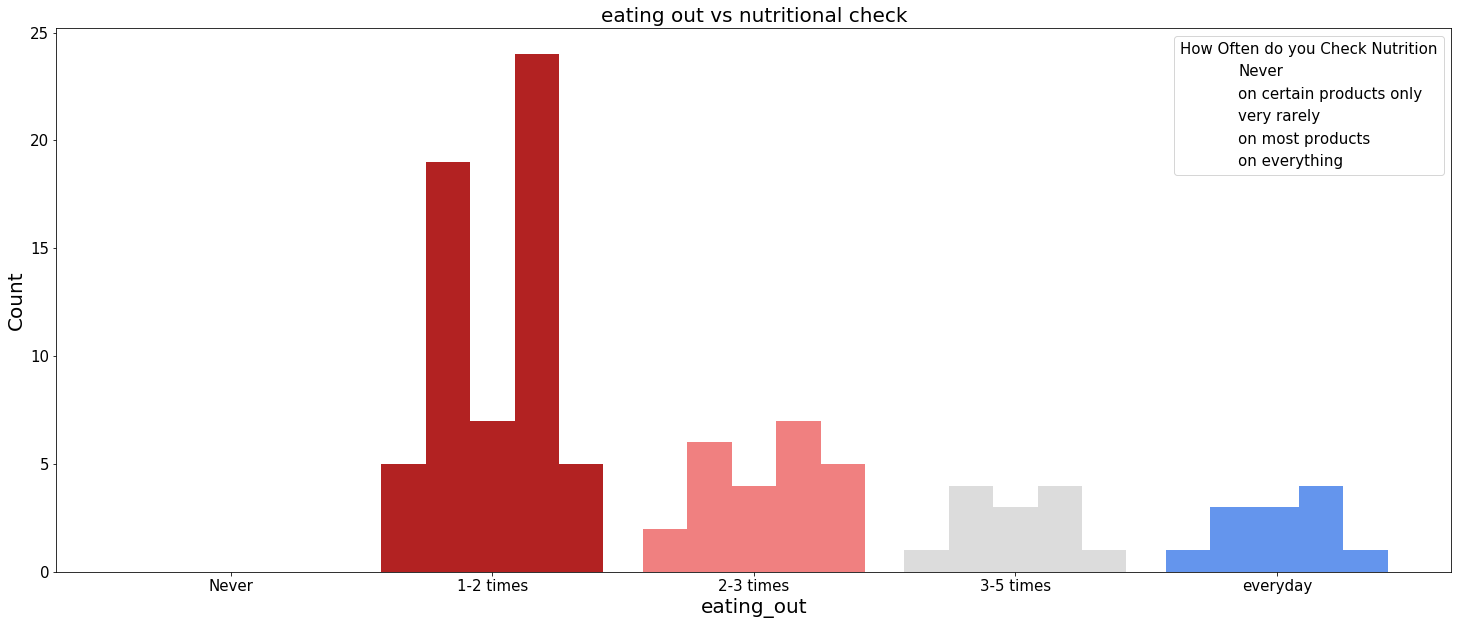

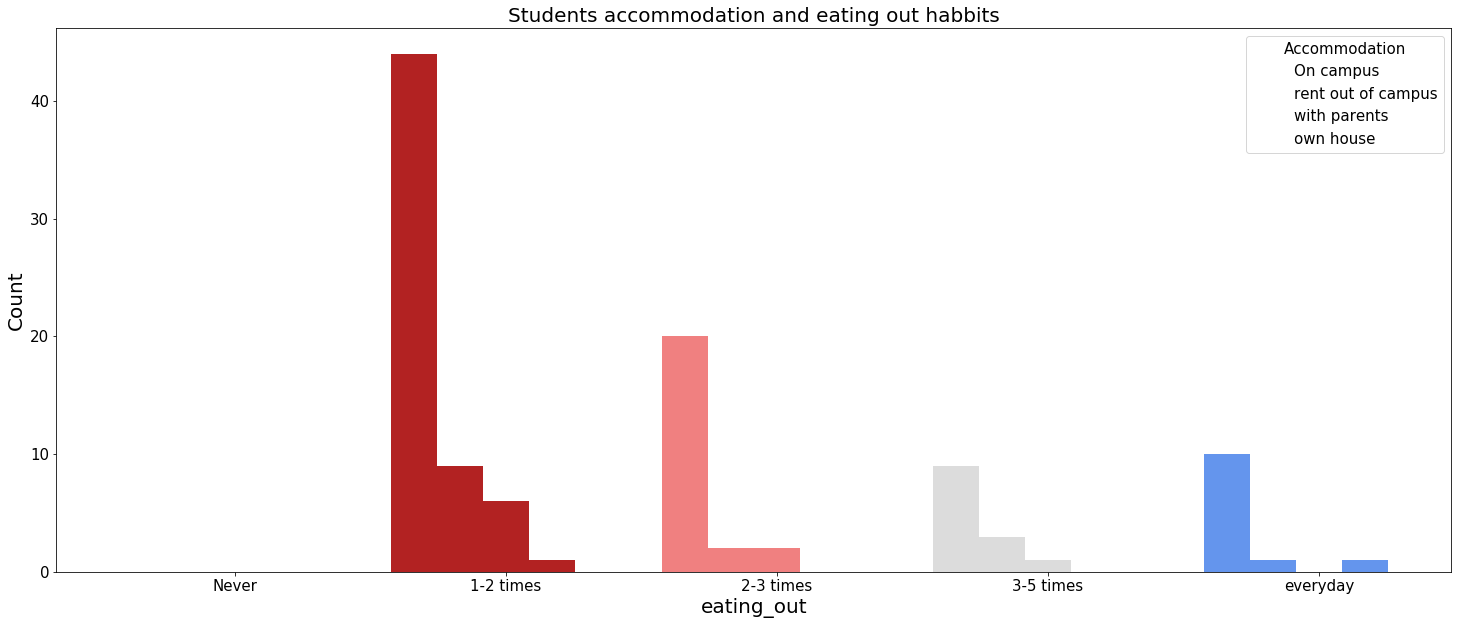

In [269]:
data = loaddata()

x_attribute = 'GPA'
y_attribute = 'eating_out'

def boxplot(attribute):
    plt.figure(dpi=100, figsize=(10,10))
    plt.rc('axes', axisbelow=True)
    plt.boxplot([list(data.query('Gender==1')[attribute].dropna()), list(data.query('Gender==2')[attribute].dropna())], labels=["Male", "Female"])
    plt.rc('axes', axisbelow=True)
#     plt.boxplot()
    plt.xlabel(attribute)
    plt.show()

def bubble_chart(x_attribute, y_attribute):    
    plt.figure(dpi=100, figsize=(25,15))
    
    x_axis = data[x_attribute].round(decimals=1).dropna().unique()
    for mark in x_axis:
        y_axis =  data.query('%s == %f' % (x_attribute, mark))[y_attribute].dropna().unique()
        s = [(20 * len(data.query('%s == %f & %s == %f' % (x_attribute, mark, y_attribute, i) ))) ** 2 for i in y_axis]
        plt.scatter([mark]*len(y_axis), y_axis, s = s)

    # plt.rcParams["figure.figsize"] = (15, 20)
    y_ticks = data[y_attribute].round(decimals=1).dropna().unique()
    plt.yticks(y_ticks)
    plt.ylabel(y_attribute, fontsize= 16)
    plt.xlabel(x_attribute, fontsize= 16)
    plt.margins(0.1)
    plt.legend(x_axis)
#     plt.legend(handler= x_axis[1:3])
    plt.figure(dpi=40)
    plt.show()

    
def grouped_barchart(x_attribute, x_labels, y_attribute, legend, legend_title, plot_title=''):
    plt.clf()
    plt.rcParams['figure.figsize'] = (25,10)
    fig, ax = plt.subplots()

    x_axis_unique = data[x_attribute].round(decimals=1).dropna().unique()
    x_axis_unique.sort()

    y_axis_unique = data[y_attribute].round(decimals=1).dropna().unique()
    y_axis_unique.sort()

    ind = np.arange(len(x_axis_unique))    # the x locations for the groups
    width = 0.17                           # the width of the bars
    likert_colors = ['white', 'firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
    for i in xrange(len(y_axis_unique)):
        y = y_axis_unique[i]
        counts = []
        for x in x_axis_unique:
            counts += [len(data.query('%s == %f & %s == %f' % (x_attribute, x, y_attribute, y)))]
        plt.bar(ind + i*width, counts, width, bottom=0, color=likert_colors)
    
    if plot_title == '': plot_title = ('%s vs %s' % (x_attribute.replace('_', ' '), y_attribute.replace('_', ' ')))
    ax.set_title(plot_title,  fontsize=20)
    ax.set_xticks(ind + 4*width / 2)
    ax.set_xticklabels(x_labels)
#     ax.legend((p1[0], p2[0]), ('Men', 'Women'))
    plt.xlabel(x_attribute, fontsize=20)
    plt.ylabel('Count', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt_legend = plt.legend(legend, title=legend_title, fontsize=15)
    plt_legend.get_title().set_fontsize('15')
    plt.show()


grouped_barchart('eating_out', ['Never', '1-2 times', '2-3 times', '3-5 times', 'everyday'], 'nutritional_check', ['Never', 'on certain products only', 'very rarely', 'on most products', 'on everything'], 'How Often do you Check Nutrition')
grouped_barchart('eating_out', ['Never', '1-2 times', '2-3 times', '3-5 times', 'everyday'], 'on_off_campus', ['On campus', 'rent out of campus', 'with parents', 'own house'], 'Accommodation', 'Students accommodation and eating out habbits')
# bubble_chart('GPA', 'employment')
# boxplot('weight')

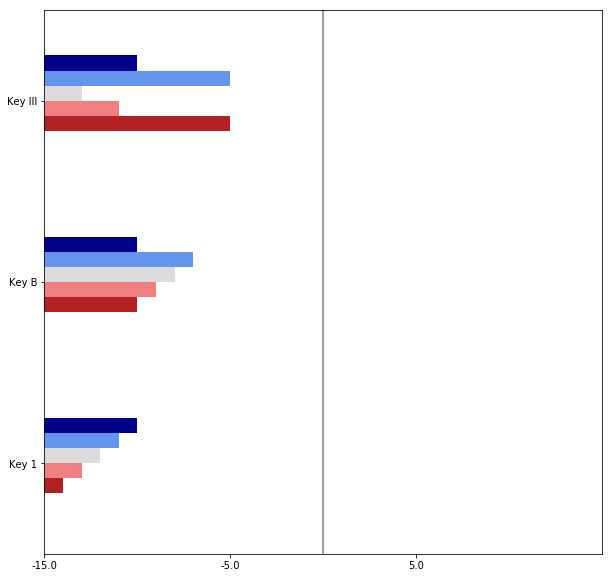

In [267]:
plt.clf()
plt.rcParams['figure.figsize'] = (10,10)
likert_colors = ['white', 'firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
dummy = pd.DataFrame([[1,2,3,4, 5], [5,6,7,8, 5], [10, 4, 2, 10, 5]],
                     columns=["SD", "D", "N", "A", "SA"],
                    index=["Key 1", "Key B", "Key III"])
middles = dummy[["SD", "D"]].sum(axis=1)+dummy["N"]*.5
longest = middles.max()
dummy.insert(0, '', (middles - longest).abs())

dummy.plot.barh(color=likert_colors, edgecolor='none', legend=False)
z = plt.axvline(longest, linestyle='-', color='black', alpha=0.5)
z.set_zorder(-1)

complete_longest = 30
plt.xlim(0, complete_longest)
xvalues = range(0,complete_longest,10)
xlabels = [str(x-longest) for x in xvalues]
plt.xticks(xvalues, xlabels)
plt.show()

In [63]:
data.father_profession.unique()

GPA                           121
Gender                        125
breakfast                     125
calories_chicken              125
calories_day                  106
calories_scone                124
coffee                        125
comfort_food                  124
comfort_food_reasons          124
cook                          122
comfort_food_reasons_coded    125
cuisine                       108
diet_current                  124
diet_current_coded            125
drink                         123
eating_changes                122
eating_changes_coded          125
eating_changes_coded1         125
eating_out                    125
employment                    116
ethnic_food                   125
exercise                      112
father_education              124
father_profession             122
fav_cuisine                   123
fav_cuisine_coded             125
fav_food                      123
food_childhood                124
fries                         125
fruit_day     